# Stock Market Analysis & Prediction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
import warnings
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, AveragePooling1D
%matplotlib inline
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fetch The Data


The data that we will be using a year worth of stock data from technology company including 'Apple', 'Google', 'Microsoft', 'Amazon'. We will use `yfinance` library in order to fetch the stock data

In [26]:
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

end = datetime.now()
start = end - timedelta(days=365)

# start='2015-01-01'
# end=datetime.now()

stock_data = {}

for stock in tech_list:
    stock_data[stock] = yf.download(stock, start, end, auto_adjust='False')


for stock, name in zip(tech_list, company_name):
    stock_data[stock]["company_name"] = name

df = pd.concat(stock_data.values(), axis=0)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Basic Exploratory Data Analysis

## Descriptive Statistics

`.describe` generate descriptive statistics. Provides a quick overview of the central tendency, dispersion, and shape of the dataset's distribution, excluding `NaN` (missing) values. 

In [87]:
for ticker in tech_list:
    print(f"\n{ticker} Summary (Central Tendencies, Dispersion, Shape)\n {'='*50}")
    print(stock_data[ticker].describe().round(2))


AAPL Summary (Central Tendencies, Dispersion, Shape)
Price    Close    High     Low    Open        Volume
Ticker    AAPL    AAPL    AAPL    AAPL          AAPL
count   250.00  250.00  250.00  250.00  2.500000e+02
mean    222.97  225.25  220.24  222.59  5.634951e+07
std      15.38   14.89   15.85   15.59  3.241535e+07
min     172.19  190.09  168.99  171.72  2.323470e+07
25%     213.13  215.23  210.59  212.87  3.973505e+07
50%     224.21  226.07  222.23  224.17  4.804335e+07
75%     232.52  234.26  229.18  232.45  6.041002e+07
max     258.40  259.47  257.01  257.57  3.186799e+08

GOOG Summary (Central Tendencies, Dispersion, Shape)
Price    Close    High     Low    Open      Volume
Ticker    GOOG    GOOG    GOOG    GOOG        GOOG
count   250.00  250.00  250.00  250.00       250.0
mean    173.54  175.63  171.64  173.60  20274182.4
std      13.19   13.07   13.21   13.03   9433940.4
min     146.58  151.06  142.66  143.39   6809800.0
25%     164.15  166.37  162.97  164.42  14087450.0
50%  

## Closing Price

The price of the last trade for a particular stock at the end of a regular trading session on an exchange

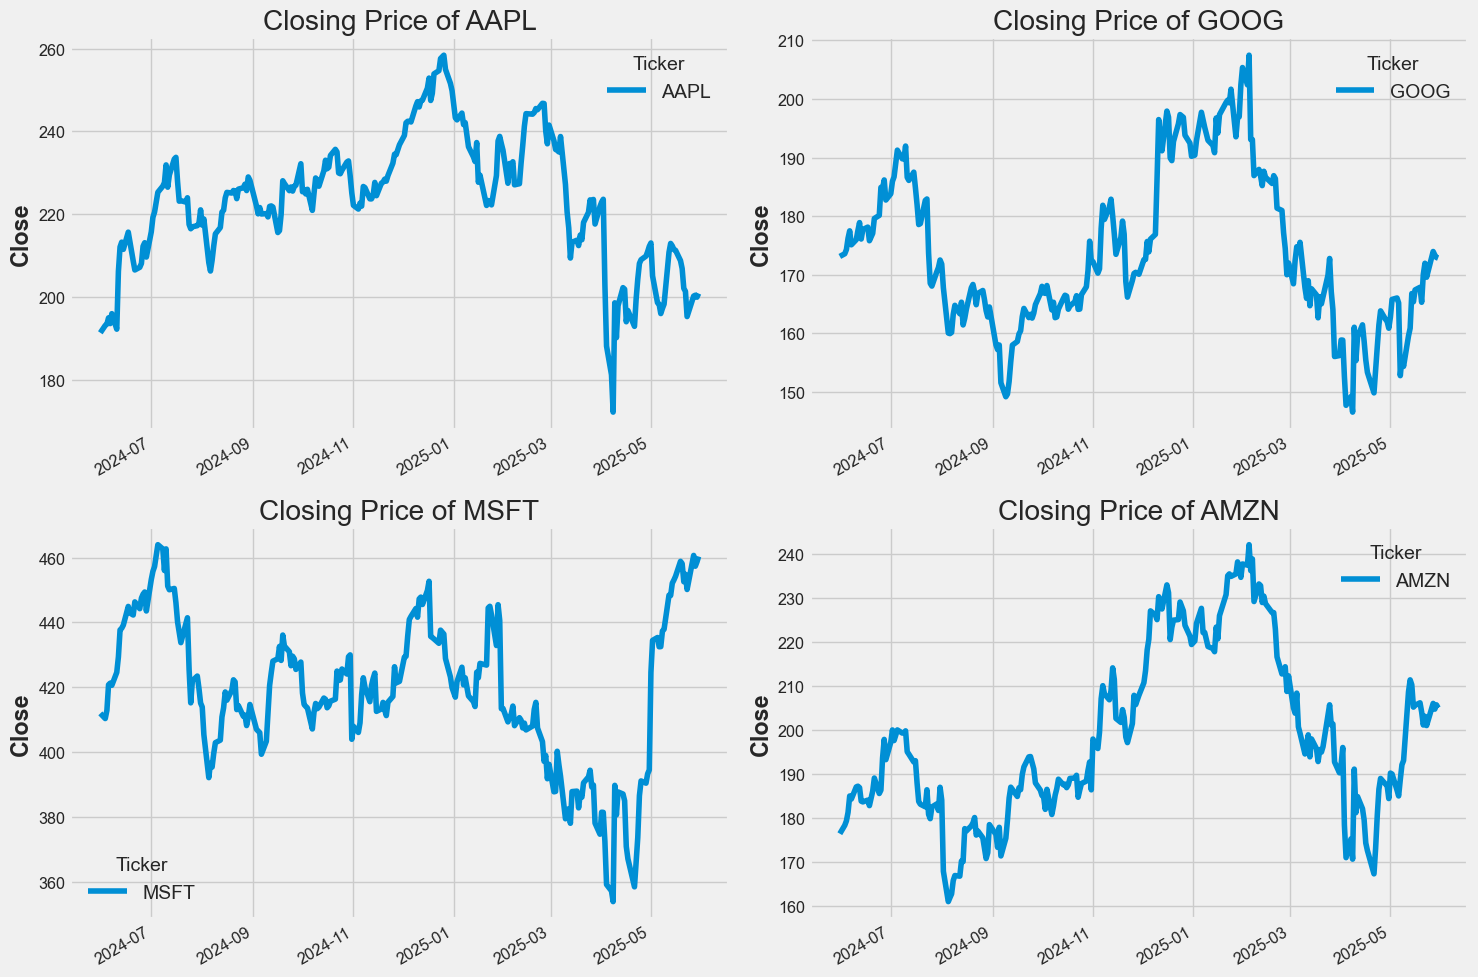

In [88]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid

for ax, ticker in zip(axes.flat, tech_list):
    stock_data[ticker]['Close'].plot(ax=ax)
    ax.set_ylabel('Close')
    ax.set_xlabel(None)
    ax.set_title(f"Closing Price of {ticker}")

plt.tight_layout()
plt.show()

## OHLC (Open, High, Low, Close) Plot

OHLC stands for Open, High, Low, Close. It's a way to represent the price movement of a security (like a stock) over a specific period, such as a day or hour. Each OHLC data point provides a snapshot of the trading session, showing the opening price, the highest price reached, the lowest price reached, and the closing price. 

In [89]:
from plotly import graph_objects as go

for stock in tech_list:
    df_stock = stock_data[stock].copy()
    fig = go.Figure(data=[go.Candlestick(
        x=df_stock.index,
        open=df_stock['Open'][stock],
        high=df_stock['High'][stock],
        low=df_stock['Low'][stock],
        close=df_stock['Close'][stock],
        name=stock
    )])

    fig.update_layout(
        title=f'OHLC Price of {stock}',
        xaxis_title='Date',
        yaxis_title='Price (USD)',
        xaxis_rangeslider_visible=True,
        template='plotly_dark',
        height=700,
        width=1100,
    )

    fig.show()

## Volume of sales

total number of shares that are bought or sold (traded) within a specific period of time 

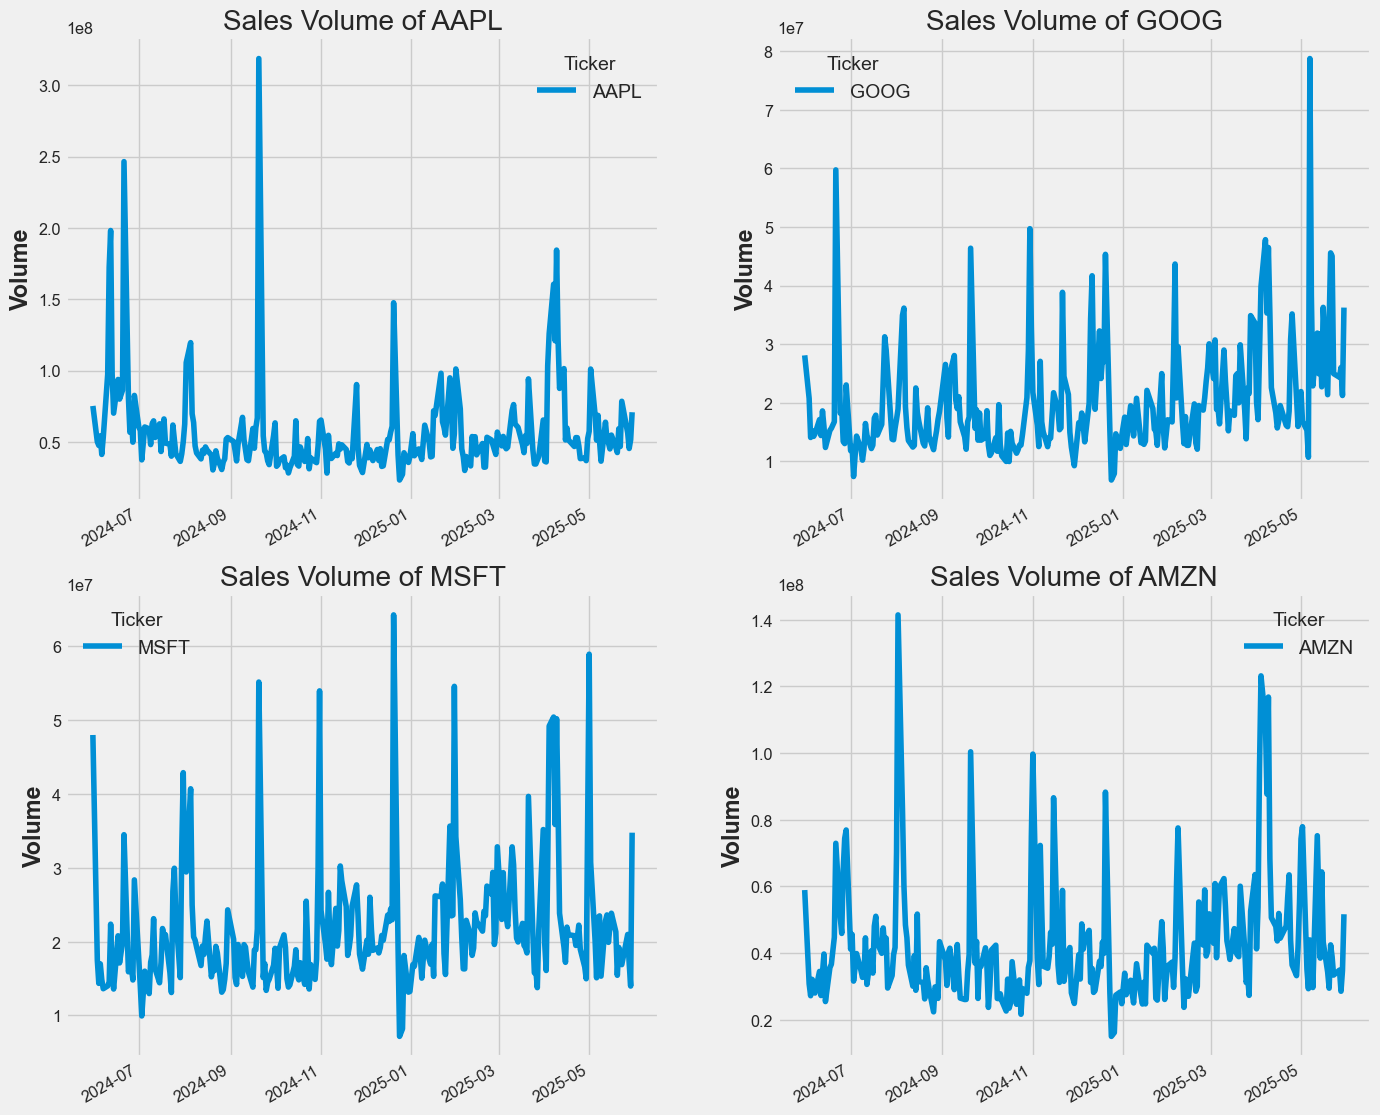

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))  # 2x2 grid
for ax, ticker in zip(axes.flat, tech_list):  # Flatten grid
    stock_data[ticker]['Volume'].plot(ax=ax)
    ax.set_ylabel('Volume')
    ax.set_xlabel(None)
    ax.set_title(f"Sales Volume of {ticker}")


All four stocks exhibit highly volatile trading volumes, characterized by frequent and significant spikes, which likely correspond to earnings releases, major news events, or broader market shifts, as some spikes appear correlated across the different tech giants. While the general pattern of volatility is similar, the absolute volume scales differ, with AAPL and AMZN generally showing higher peak volumes than GOOG, and MSFT showing the lowest among the group

## Moving Average of Each Stock

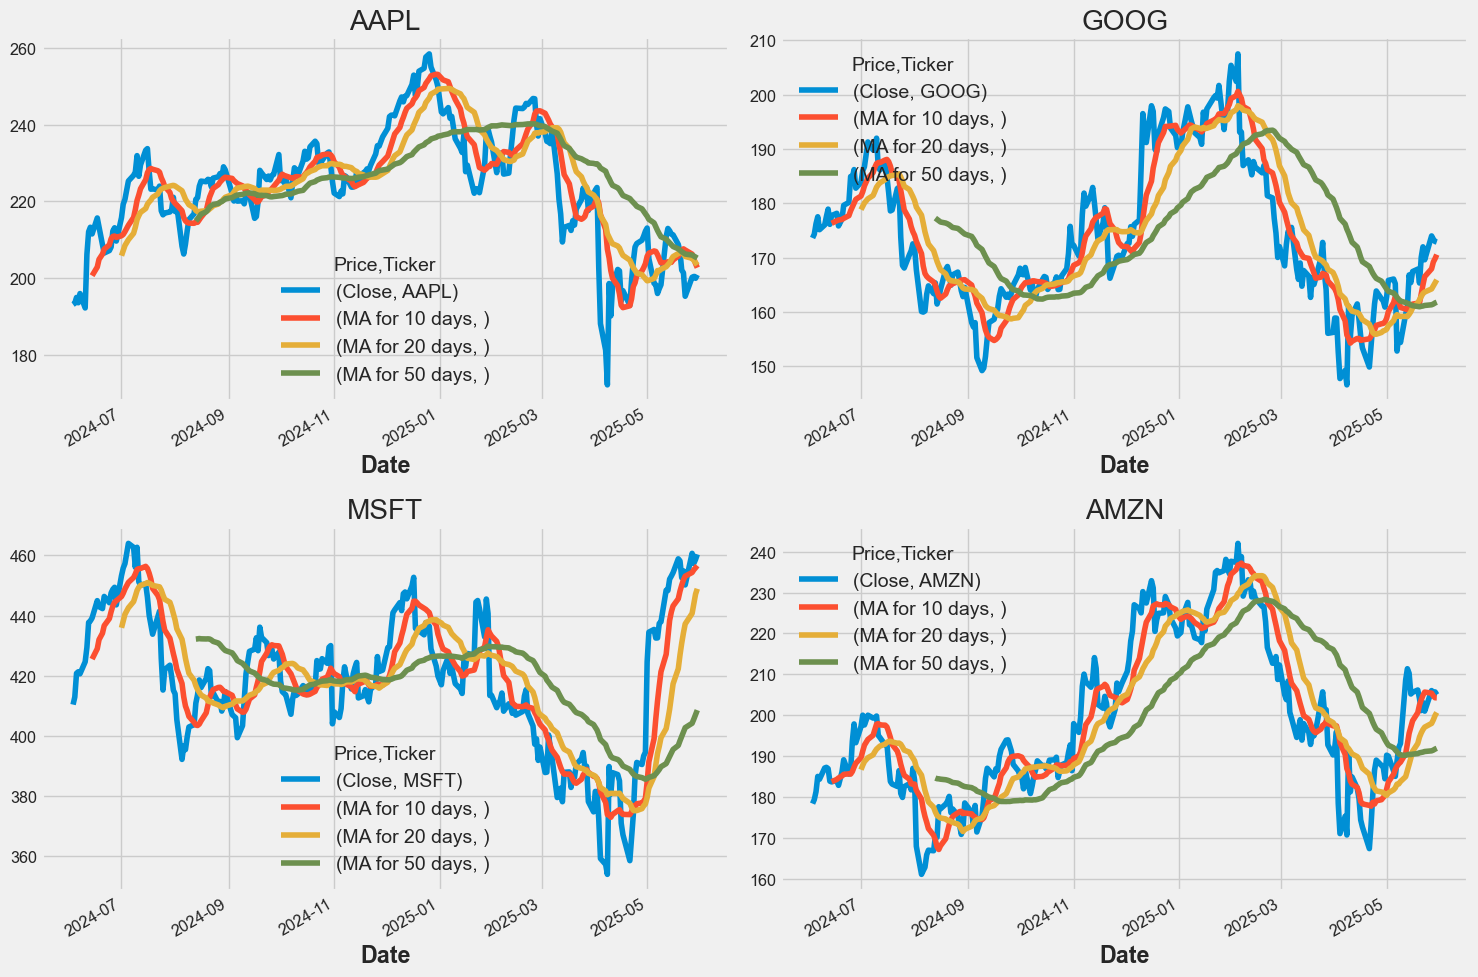

In [ ]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for ticker in tech_list:
        column_name = f"MA for {ma} days"
        stock_data[ticker][column_name] = stock_data[ticker]['Close'].rolling(ma).mean()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

fig.set_figheight(10)
fig.set_figwidth(15)
for ax, ticker in zip(axes.flat, tech_list):
    stock_data[ticker][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax)
    ax.set_title(f"{ticker}")



# stock_data['AAPL'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0, 0])
# axes[0, 0].set_title('APPLE')

# stock_data['GOOG'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0, 1])
# axes[0, 1].set_title('GOOGLE')

# stock_data['MSFT'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1, 0])
# axes[1, 0].set_title('MICROSOFT')

# stock_data['AMZN'][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1, 1])
# axes[1, 1].set_title('AMAZON')

fig.tight_layout()
plt.show()


The 10-day and 20-day moving averages closely track short-term price movements, while the 50-day moving average smooths out longer-term trends, highlighting overall directional shifts more gradually.

## Daily Returns (Percentage Change)

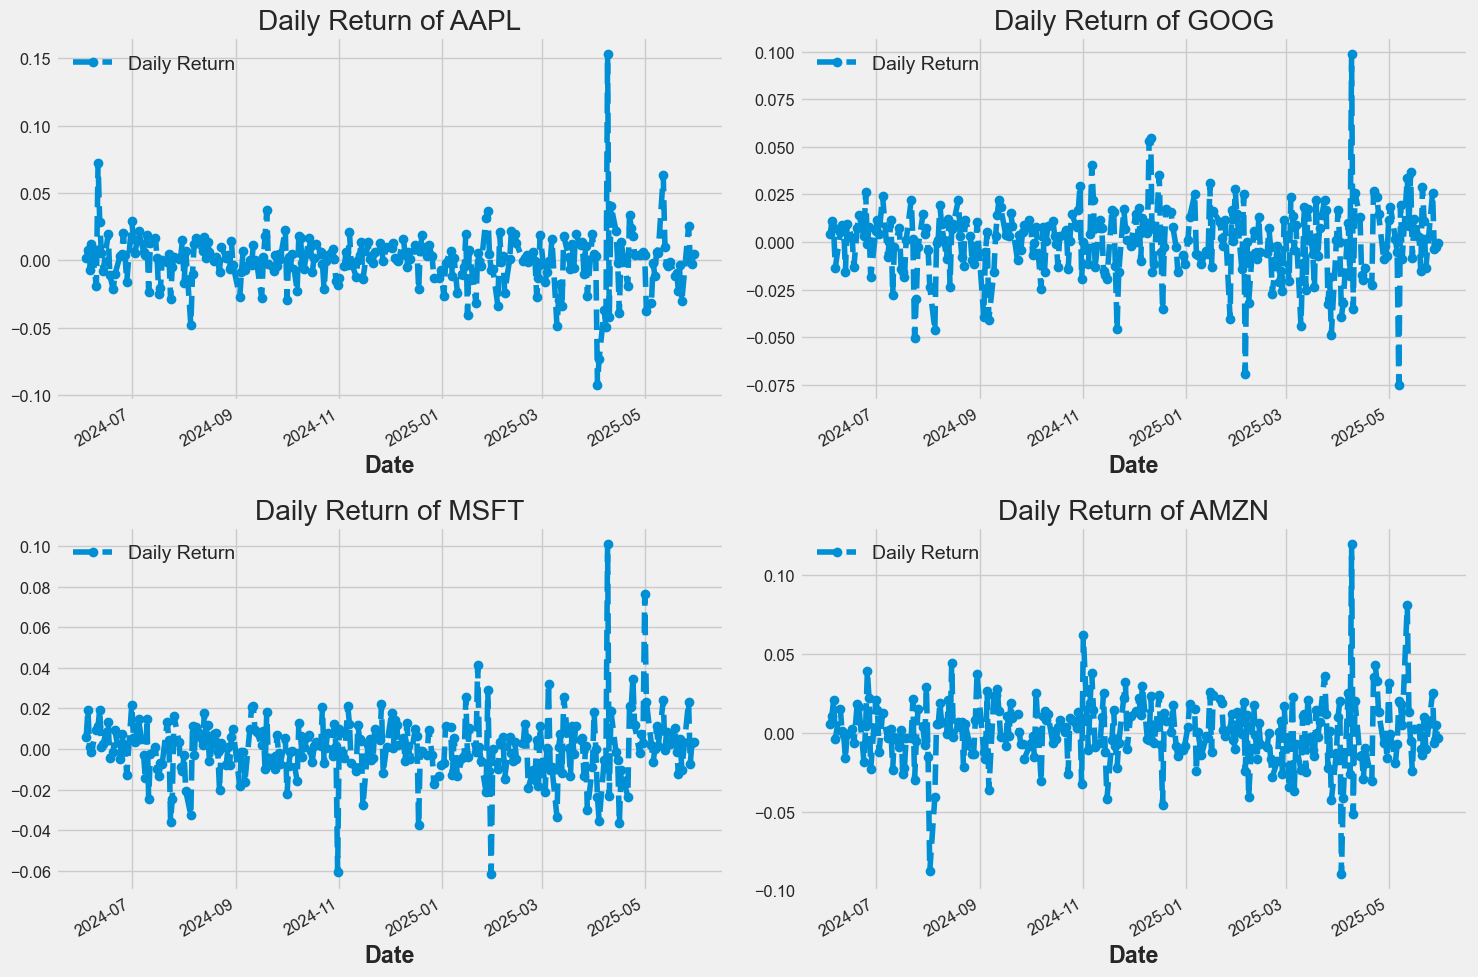

In [ ]:
fig, axes = plt.subplots(2, 2)  # 2x2 grid
fig.set_figheight(10)
fig.set_figwidth(15)
for ax, ticker in zip(axes.flat, tech_list):
    stock_data[ticker]['Daily Return'].plot(
        ax=ax, 
        legend=True,
        linestyle='--', 
        marker='o')
    ax.set_title(f"Daily Return of {ticker}")
    
plt.tight_layout()
plt.show()

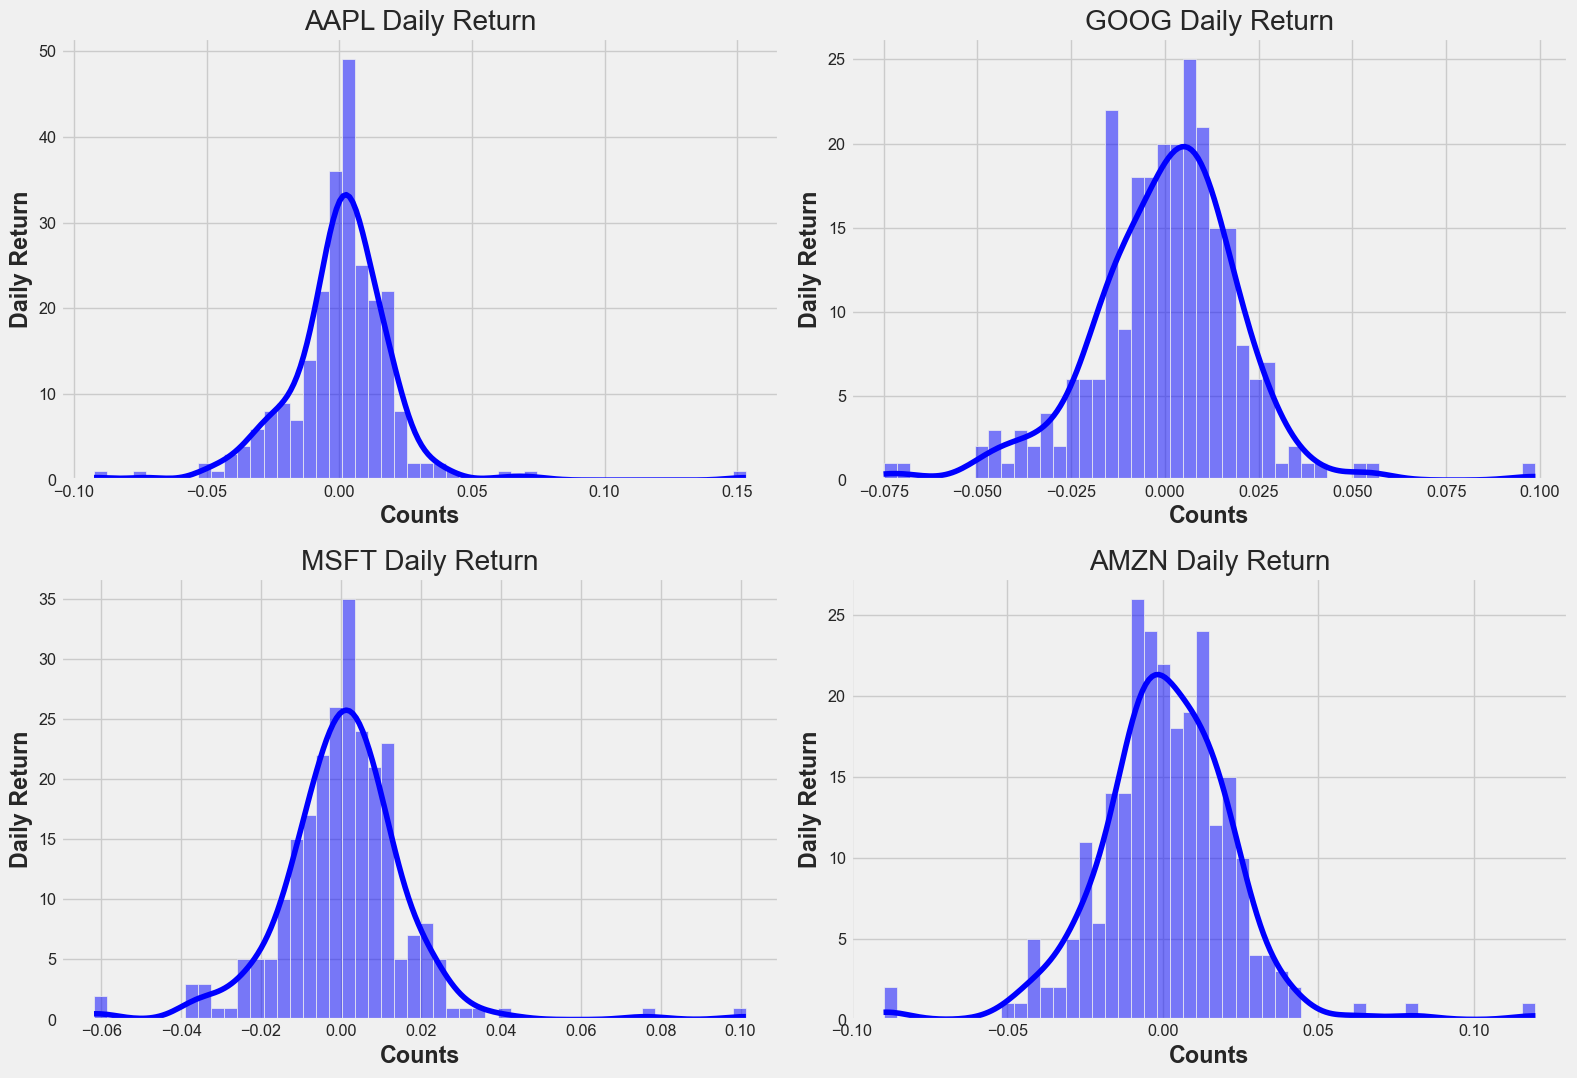

In [93]:
fig, axes = plt.subplots(2,2, figsize=(16,11))
for ax, ticker in zip(axes.flat, tech_list):
    sns.histplot(stock_data[ticker]['Daily Return'].dropna(), bins=50,kde=True, color='blue',ax=ax)
    ax.set_xlabel('Counts')
    ax.set_ylabel('Daily Return')
    ax.set_title(f'{ticker} Daily Return')
    
plt.tight_layout()

Among them, AAPL and MSFT exhibit slightly more peaked and narrower distributions, suggesting less volatility compared to GOOG and AMZN, which show wider spreads and fatter tails, indicating higher variability in daily returns.

# Correlation between different stock closing prices

## Correlation Analysis

Correlation is a statistic that measures the degree to which two variables move in relation to each other which has a value that must fall between -1.0 and +1.0. Correlation measures association, but doesn’t show if x causes y or vice versa — or if the association is caused by a third factor.

In [94]:
closing_df = yf.download(tech_list, start=start, end=end)['Close']
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%***********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2024-05-31,NaN,NaN,NaN,NaN
2024-06-03,0.009259,0.010768,0.002644,-0.003878
2024-06-04,0.001649,0.005607,0.004071,0.006167
2024-06-05,0.007821,0.010817,0.011077,0.019083
2024-06-06,-0.007097,0.020521,0.007229,0.001203


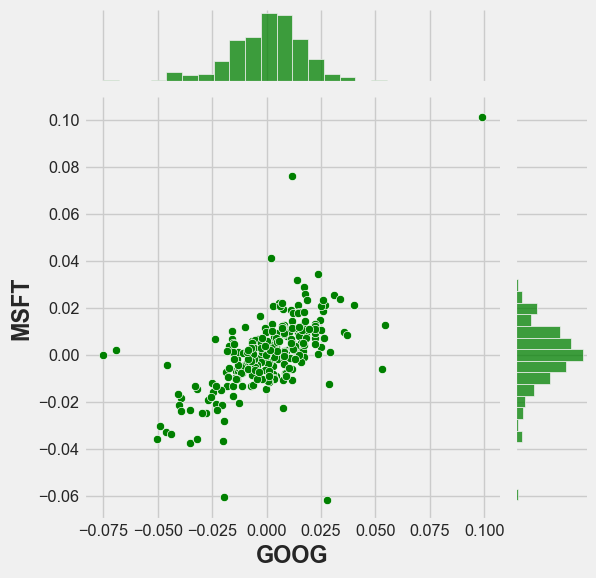

In [95]:
#compare daily returns from of google microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter', color='green')

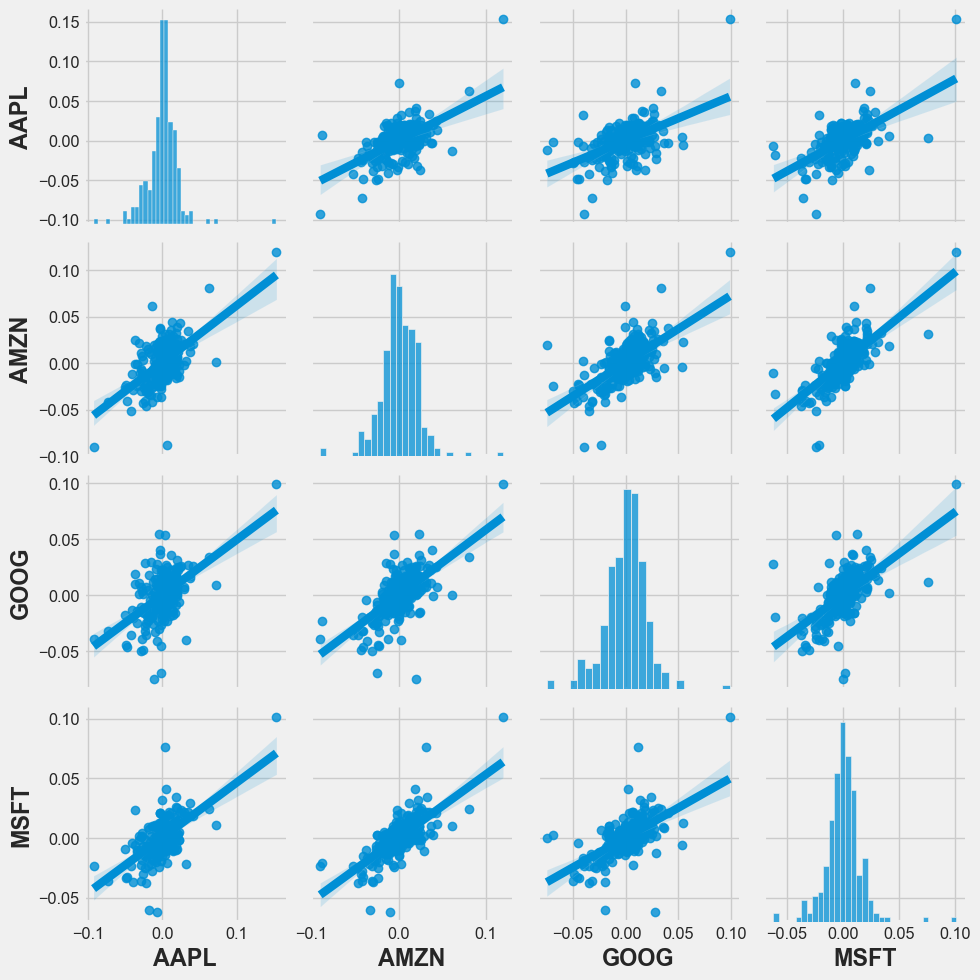

In [96]:
sns.pairplot(data=tech_rets, kind='reg')

The scatter plots are tightly clustered around the regression line, meaning the returns of these stocks are positively correlated.
This suggests that when one stock increases, the others tend to increase as well.


While the simplicity of just calling sns.pairplot() is fantastic we can also use sns.PairGrid() for full control of the figure, including what kind of plots go in the diagonal, the upper triangle, and the lower triangle. Below is an example of utilizing the full power of seaborn to achieve this resu

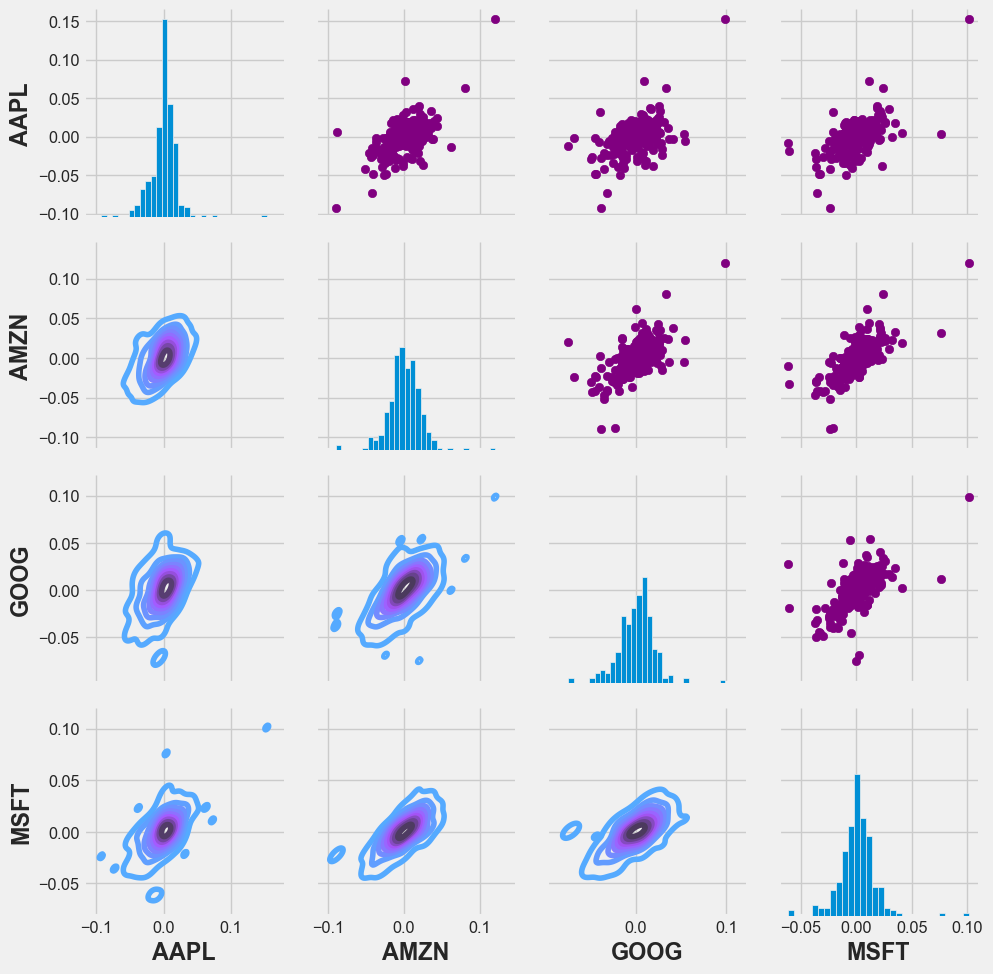

In [97]:
tech_rets_cleaned = tech_rets.replace([np.inf, -np.inf], np.nan).dropna()
return_fig = sns.PairGrid(tech_rets_cleaned)
return_fig.map_upper(plt.scatter, color="Purple")
return_fig.map_lower(sns.kdeplot, cmap="cool_d")
return_fig.map_diag(plt.hist, bins=30)


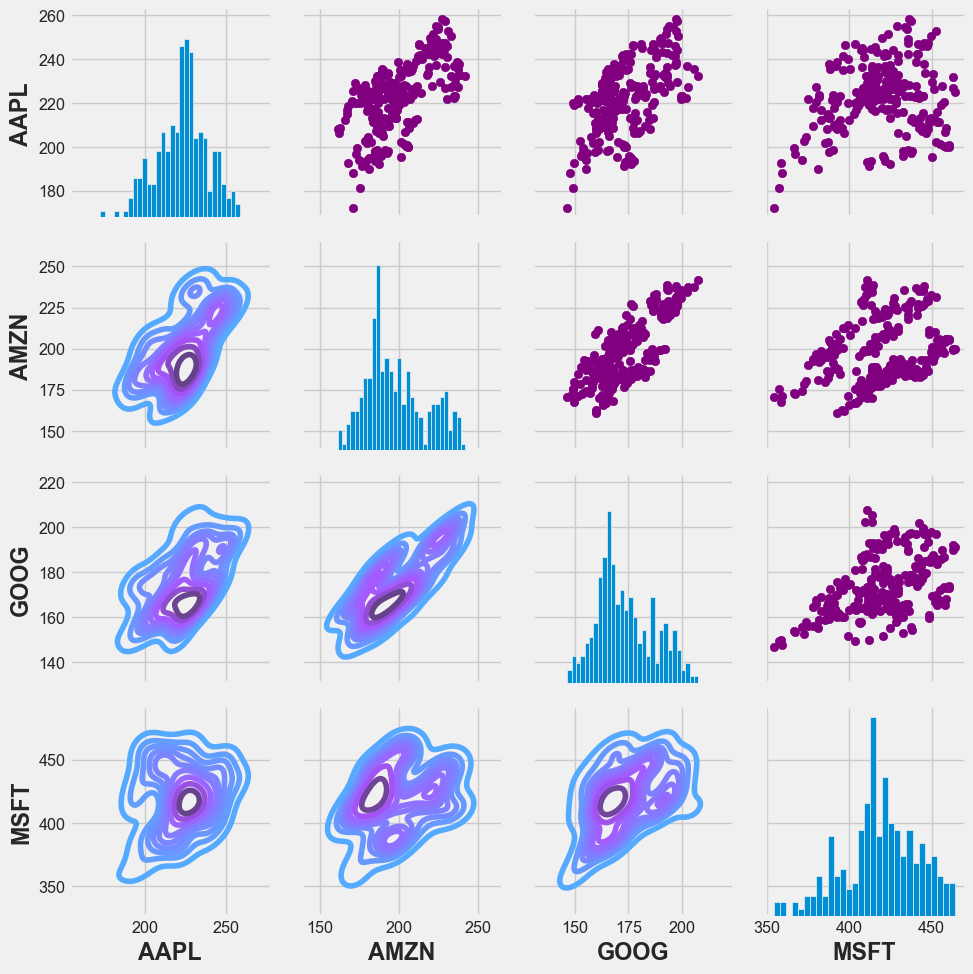

In [98]:
returns_fig = sns.PairGrid(closing_df)
returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(plt.hist,bins=30)

we could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting relationship between Microsoft and Apple.

Text(0.5, 1.0, 'Correlation of stock closing price')

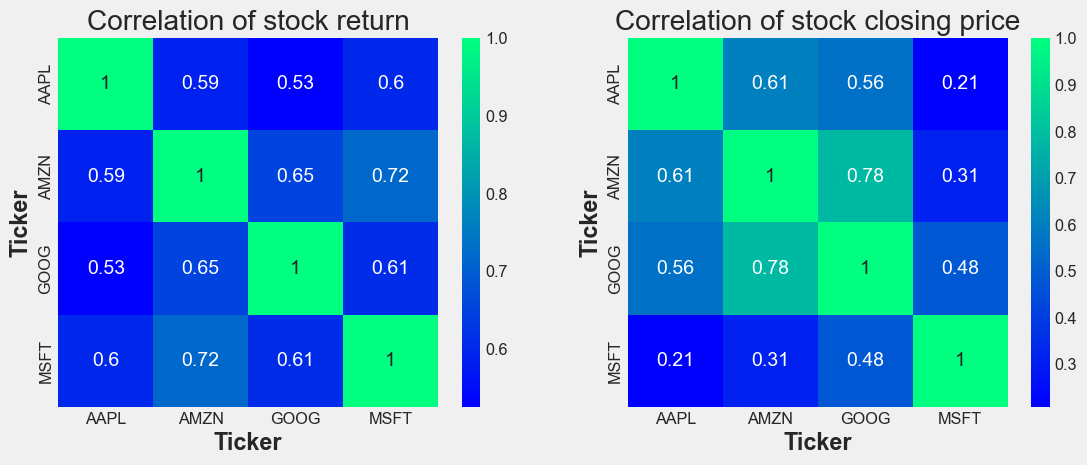

In [99]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='winter')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='winter')
plt.title('Correlation of stock closing price')


- Stock return Correlation
Stock returns among these companies are moderately to strongly correlated, which is common in the tech sector due to similar market influences.

- Stock closing Price
Correlations vary more widely. Stock prices can differ significantly in scale and don't necessarily move in sync in absolute terms, even if returns are correlated.

## Comparing Each Stock Risk and Return

Comparing the expected return with the standard deviation of the daily returns

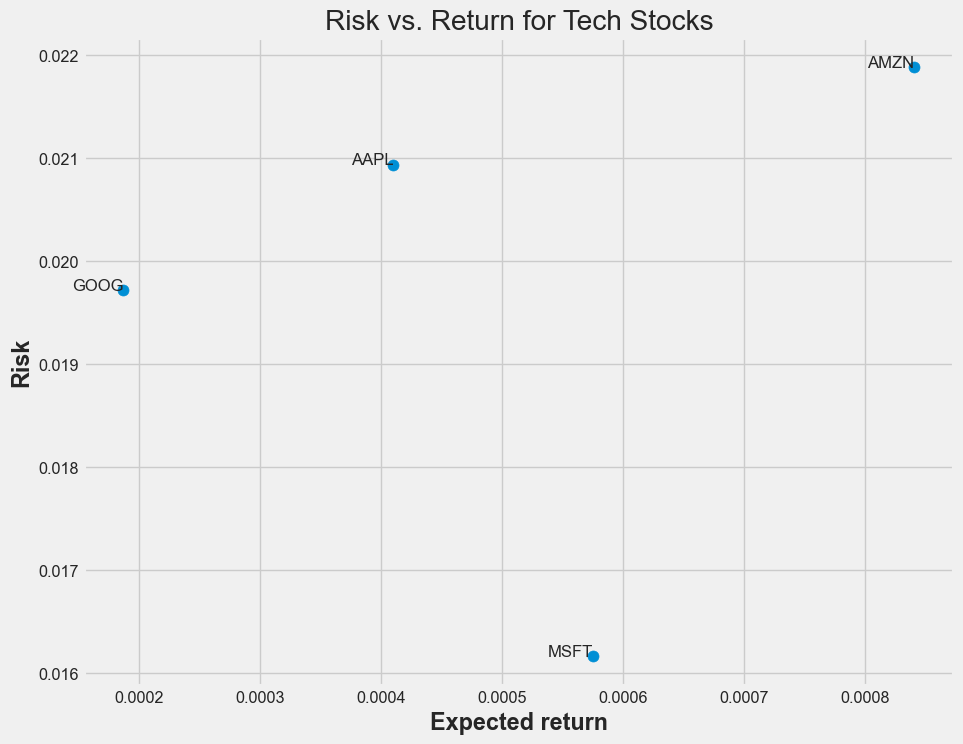

In [100]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for i, name in enumerate(rets.columns):
    plt.text(rets.mean()[i], rets.std()[i], name, fontsize=12, ha='right')

plt.title('Risk vs. Return for Tech Stocks')
plt.grid(True)
plt.show()

Amazon (AMZN) offers the highest expected return but also comes with the highest risk, while Microsoft (MSFT) provides the lowest return with the least risk, making it the most conservative option. Apple (AAPL) and Google (GOOG) lie in between, with AAPL offering a balanced profile and GOOG leaning slightly more toward higher risk and return.

# Forecasting

In [2]:
df = yf.download('AAPL', start='2020-01-01', end=datetime.now())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


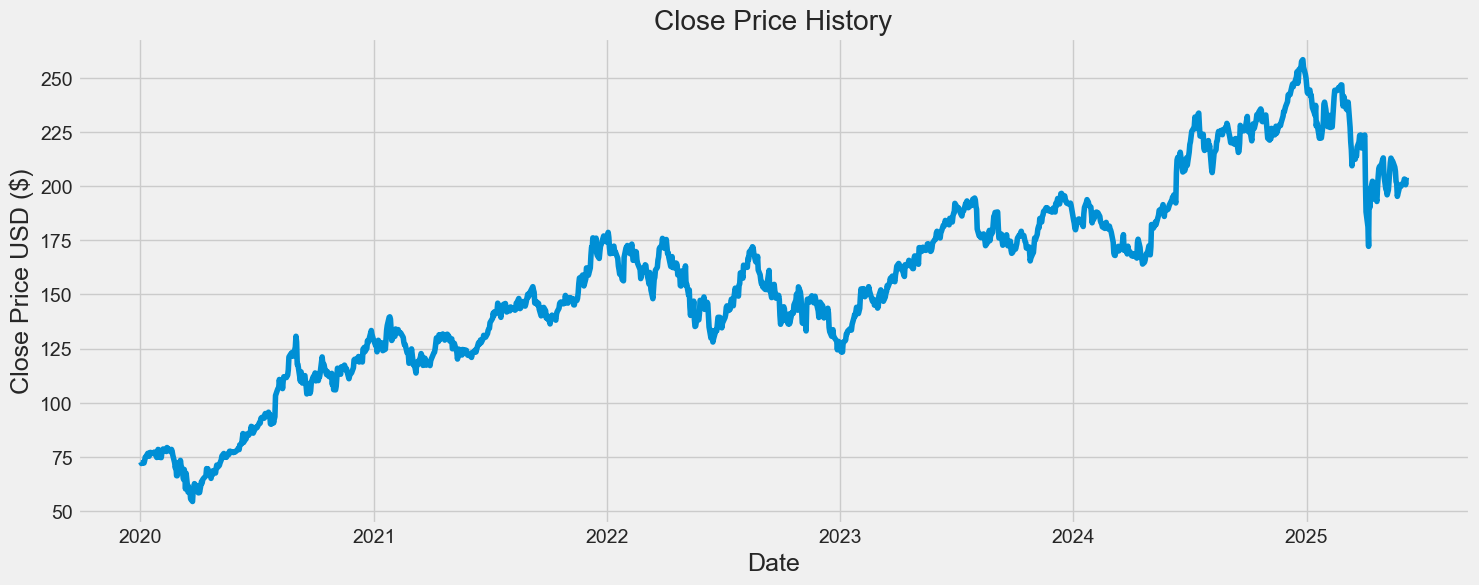

In [7]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


## Traditional Statistical Model (ARIMA)

### Adfuller Stationarity Checks function

In [3]:
def ad_fuller_func(X):
    result_ad_fuller = adfuller(X)
    print('ADF Statistic: %f' % result_ad_fuller[0])
    print('p-value: %f' %result_ad_fuller[1])
    print('Critical Values:')
    for key, value in result_ad_fuller[4].items():
        print('\t%s: %.3f' % (key, value))
    if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
        print('Reject Null Hypothesis (Time series data is Stationary)')
    else:
        print('Failed to Reject Null Hypothesis (Non Stationary)')

ad_fuller_func(df[['Close']])

ADF Statistic: -1.750475
p-value: 0.405312
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Failed to Reject Null Hypothesis (Non Stationary)


### Apply Differencing

In [4]:
df_diff = df['Close'] - df['Close'].shift(2)
df_diff.dropna(inplace=True)

In [6]:
df_diff

Ticker,AAPL
Date,
2020-01-06,-0.132980
2020-01-07,0.232132
2020-01-08,0.819664
2020-01-09,2.717674
2020-01-10,1.726349
...,...
2025-06-02,1.750000
2025-06-03,2.419998
2025-06-04,1.120010


In [5]:
ad_fuller_func(df_diff)

ADF Statistic: -7.282609
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Reject Null Hypothesis (Time series data is Stationary)


### AutoCorrelation Function (AFC)

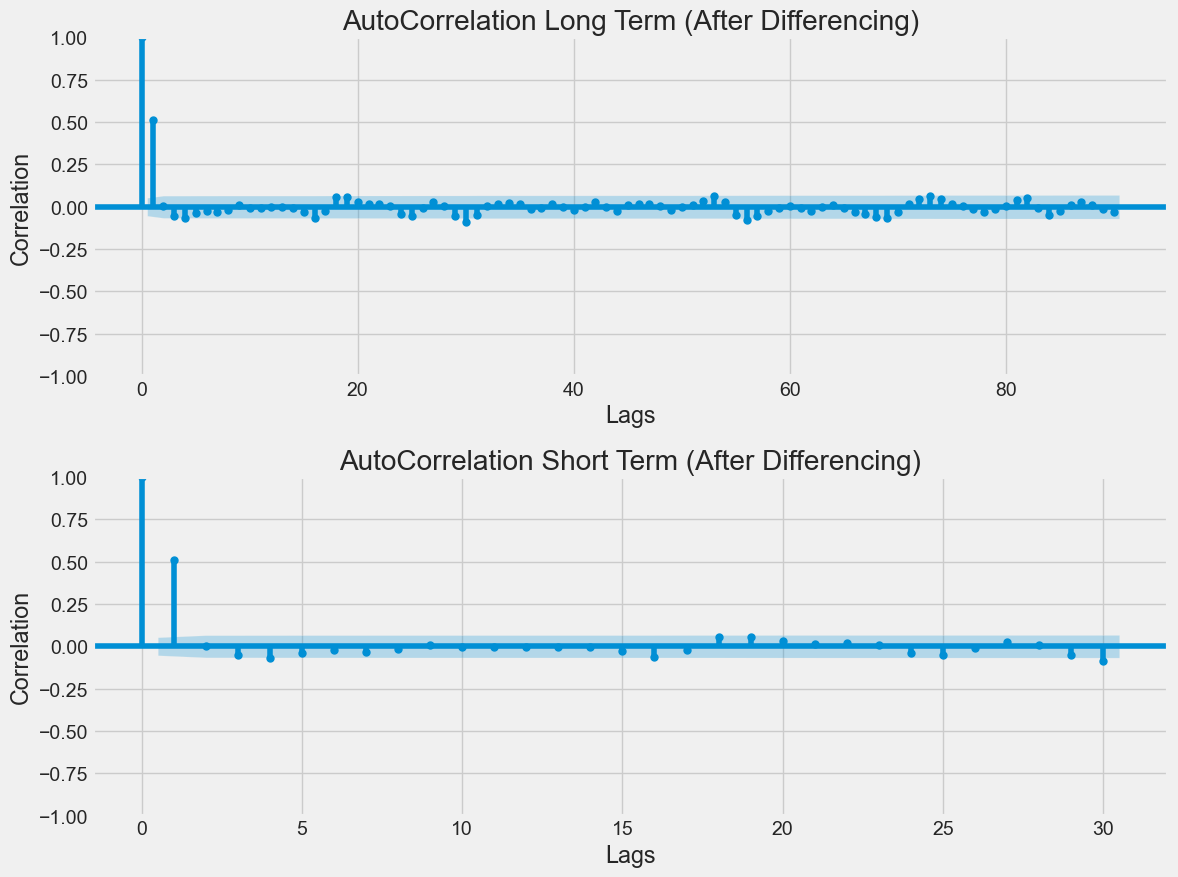

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

fig,(ax1,ax2) = plt.subplots(2,figsize=(12,9))
acf = plot_acf(df_diff,lags=90,ax=ax1)
ax1.set_title('AutoCorrelation Long Term (After Differencing)')
acf = plot_acf(df_diff,lags=30,ax=ax2)
ax2.set_title('AutoCorrelation Short Term (After Differencing)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout()
plt.show()

### Partial Auto Correlation Function (PACF)

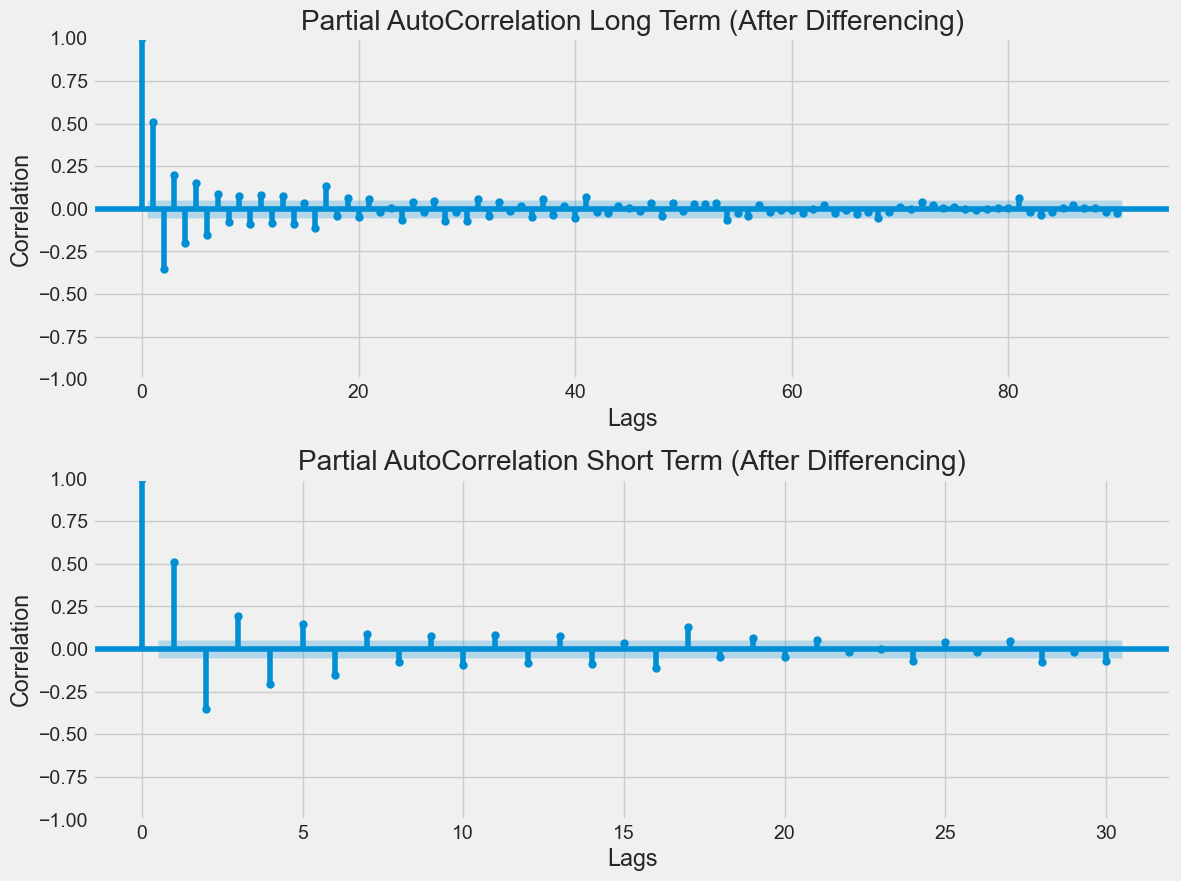

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

fig,(ax1,ax2) = plt.subplots(2,figsize=(12,9))
pacf = plot_pacf(df_diff,lags=90,ax=ax1)
ax1.set_title('Partial AutoCorrelation Long Term (After Differencing)')
pacf = plot_pacf(df_diff,lags=30,ax=ax2)
ax2.set_title('Partial AutoCorrelation Short Term (After Differencing)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

## STL Decomposition

In [ ]:
from statsmodels.tsa.seasonal import STL
n = len(df)
train_size = int(n * 0.7)
test_size = int(n * 0.15)
val_size = n - train_size - test_size
df['Close_log'] = np.log(df['Close'])
train = df[['Close_log']].iloc[:train_size]
test = df[['Close_log']].iloc[train_size:train_size + test_size]
val = df[['Close_log']].iloc[train_size + test_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}, Val size: {len(val)}")

seasonal_periods = [5, 21, 63, 252]  # Weekly, monthly, quarterly (trading days)
for period in seasonal_periods:
    stl = STL(train['Close_log'], period=period, robust=True)
    result = stl.fit()
    seasonal_strength = max(0, 1 - np.var(result.resid) / np.var(result.resid + result.seasonal))
    print(f"Seasonal Strength (period={period}): {seasonal_strength:.3f}")


Train size: 955, Test size: 204, Val size: 206
Seasonal Strength (period=5): 0.039
Seasonal Strength (period=21): 0.046
Seasonal Strength (period=63): 0.110


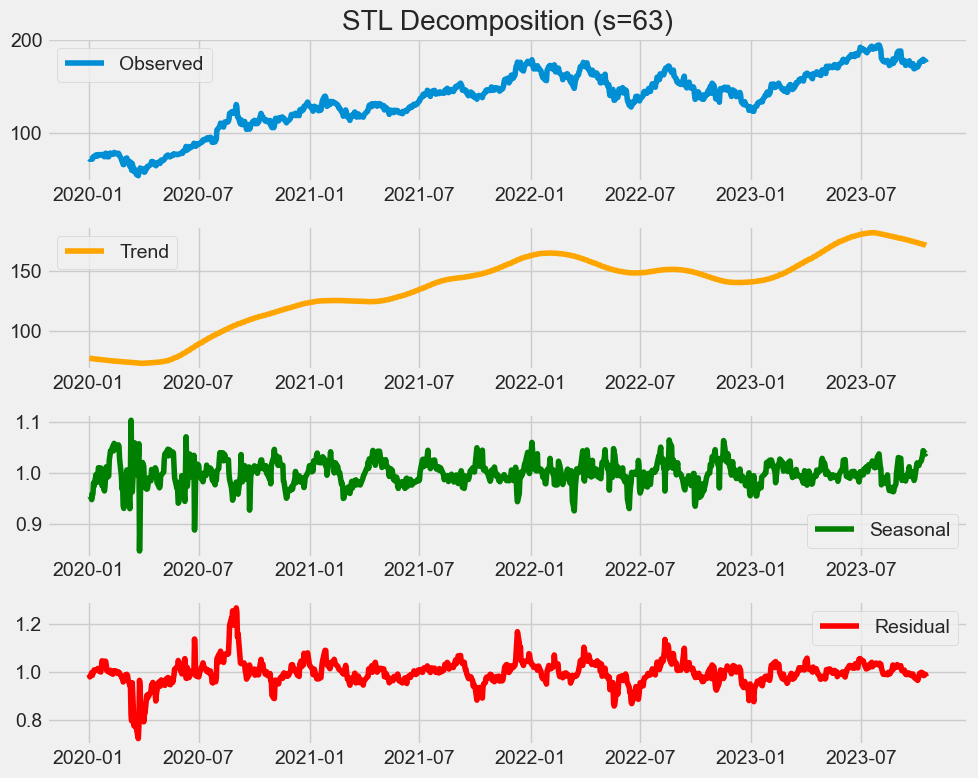

In [13]:
stl = STL(train['Close_log'], period=63, robust=True)

result = stl.fit()
trend = np.exp(result.trend)
seasonal = np.exp(result.seasonal)  # Approximate for visualization
residual = np.exp(result.resid)  # Approximate
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(train.index, np.exp(train['Close_log']), label='Observed')
plt.title('STL Decomposition (s=63)')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(train.index, trend, label='Trend', color='orange')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(train.index, seasonal, label='Seasonal', color='green')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(train.index, residual, label='Residual', color='red')
plt.legend()
plt.tight_layout()
plt.show()

###  Fitting ARIMA

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


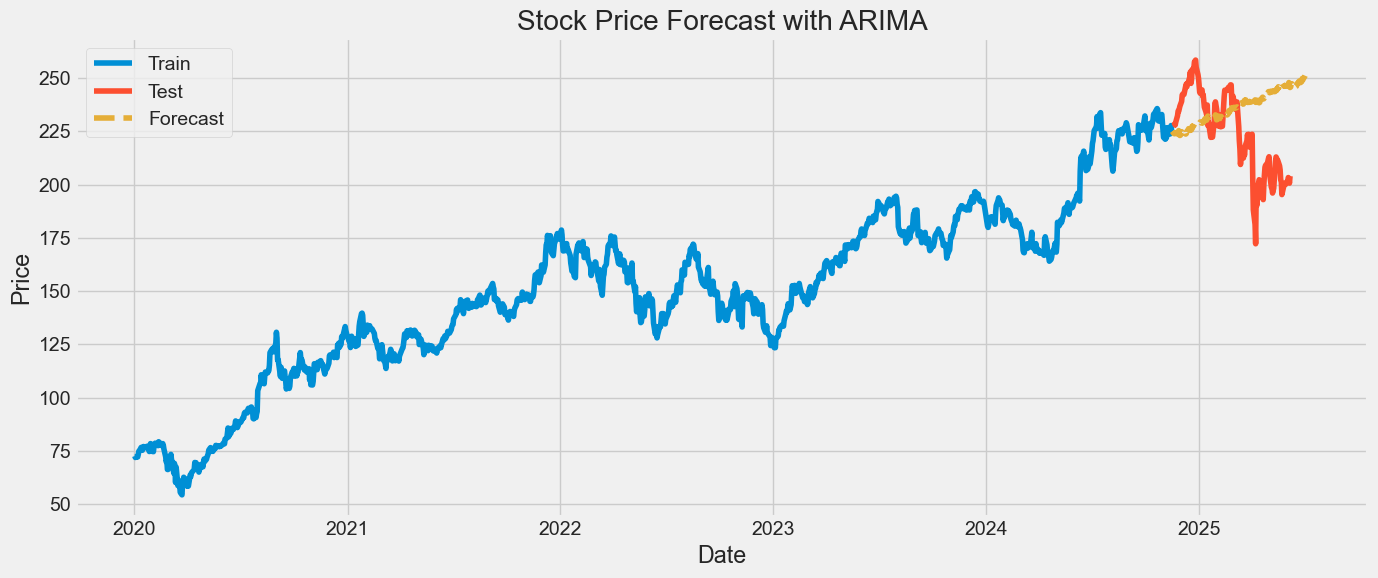

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Prepare data
df = df[['Close']].dropna()
df.index = pd.to_datetime(df.index)

# Split into train, test, validation
n = len(df)
train_size = int(n * 0.9)

train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Fit ARIMA model on training data
model = ARIMA(train['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 63))
results = model.fit()

forecast_steps = len(test) + len(val) + 30

# Use business day frequency for forecast index
# forecast_index = pd.date_range(start=train.index[-1] + pd.tseries.offsets.BDay(1), periods=forecast_steps)

forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

forecast = results.forecast(steps=forecast_steps)
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot all data with forecast
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(forecast_index, forecast_series, label='Forecast', linestyle='--')
plt.title('Stock Price Forecast with ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
test_forecast = forecast_series[:len(test)]
rmse = np.sqrt(np.mean(((test_forecast - test['Close']['AAPL']) ** 2)))
print(f"SARIMAX Root Mean Squared Errors(RMSE): {rmse}")

SARIMAX Root Mean Squared Errors(RMSE): 15.385492494334224


## Deep Learning (LSTM , CNN+LSTM)

In [3]:
data = df['Close']
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .95))
training_data_len

1297

In [50]:
print(type(data), type(dataset))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.08941501],
       [0.0859543 ],
       [0.08876313],
       ...,
       [0.72758955],
       [0.71685519],
       [0.73298118]])

In [5]:
train_data = scaled_data[:training_data_len, :]
test_data = scaled_data[training_data_len - 60: , :]
x_train = []
y_train = []
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_train, y_train, x_test= np.array(x_train), np.array(y_train), np.array(x_test)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


In [6]:
def lstm_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


lstm_model = lstm_model()

lstm_history = lstm_model.fit(x_train, y_train,epochs=50)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0614
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0020
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0013
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0011
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0011
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0012
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0011
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0012
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0010
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0011
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0011
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 9.6433e-04
Epoch 13/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 8.0694e-04
Epoch 14/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 8.1123e-04
Epoch 15/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 9.4812e-04

In [7]:
lstm_predictions = lstm_model.predict(x_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Get the root mean squared error (RMSE)
lstm_rmse = np.sqrt(np.mean(((lstm_predictions - y_test) ** 2)))
print(f"LSTM Root Mean Squared Error: {lstm_rmse}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
LSTM Root Mean Squared Error: 7.327639225176295


In [8]:
def cnn_lstm():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(60,1))),
    model.add(AveragePooling1D(pool_size=1)),
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
cnn_lstm_model = cnn_lstm()

cnn_lstm_history = cnn_lstm_model.fit(x_train, y_train,epochs=50)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0598
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0017
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0010
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 8.7541e-04
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 9.1757e-04
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 8.6581e-04
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 8.0796e-04
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.3866e-04
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 9.1668e-04
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 8.7288e-04
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 6.4455e-04
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 6.0971e-04
Epoch 13/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 8.8241e-04
Epoch 14/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.2651e-04
Epoch 15/50
39/39 ━━━━━━━━━━━━━━━━━━━━

In [9]:
cnn_lstm_predictions = cnn_lstm_model.predict(x_test)
cnn_lstm_predictions = scaler.inverse_transform(cnn_lstm_predictions)

# Get the root mean squared error (RMSE)
cnn_lstm_rmse = np.sqrt(np.mean(((cnn_lstm_predictions - y_test) ** 2)))
print(f"CNN + LSTM Root Mean Squared Error: {cnn_lstm_rmse}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
CNN + LSTM Root Mean Squared Error: 6.343059172274817


In [11]:
# forecast for 30 days
n_days = 30

# Start with the last 60 known values (from full data)
last_60_days = scaled_data[-60:] # take the last 60 days from the input
lstm_forecast_input = last_60_days.reshape(1, 60, 1) # reshape to match the input model size
cnn_lstm_forecast_input = last_60_days.reshape(1, 60, 1) # reshape to match the input model size

# Store future predictions
lstm_forecasted = []
cnn_lstm_forecasted  = []

for _ in range(n_days):
    # Predict next value
    lstm_next_pred = lstm_model.predict(lstm_forecast_input)[0, 0] # the model.predict will return a 2d array, when we used [0,0] this will make the output into just a scalar
    cnn_lstm_next_pred = cnn_lstm_model.predict(cnn_lstm_forecast_input)[0, 0] # the model.predict will return a 2d array, when we used [0,0] this will make the output into just a scalar

    lstm_forecasted.append(lstm_next_pred) 
    cnn_lstm_forecasted.append(cnn_lstm_next_pred)
    

    # Update input sequence
    lstm_new_input = np.append(lstm_forecast_input.flatten()[1:], lstm_next_pred) # convert 3d shape array to a 1d array of 60 elements
    cnn_lstm_new_input = np.append(cnn_lstm_forecast_input.flatten()[1:], cnn_lstm_next_pred) # convert 3d shape array to a 1d array of 60 elements
    lstm_forecast_input = lstm_new_input.reshape(1, 60, 1)
    cnn_lstm_forecast_input = cnn_lstm_new_input.reshape(1, 60, 1)

# Inverse transform forecasted values to original scale
lstm_forecasted_prices = scaler.inverse_transform(np.array(lstm_forecasted).reshape(-1, 1))
cnn_lstm_forecasted_prices = scaler.inverse_transform(np.array(cnn_lstm_forecasted).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

In [12]:
print("LSTM Forecasted prices for next", n_days, "days:")
print(lstm_forecasted_prices.flatten())

LSTM Forecasted prices for next 30 days:
[200.09486 199.09198 197.55899 195.92119 194.32016 192.80128 191.37576
 190.03728 188.76944 187.55234 186.3668  185.19777 184.03531 182.87477
 181.71585 180.56146 179.41618 178.28526 177.1735  176.08456 175.02107
 173.98401 172.97345 171.98839 171.0273  170.0883  169.16943 168.26881
 167.38481 166.51598]


In [13]:
print("CNN + LSTM Forecasted prices for next", n_days, "days:")
print(cnn_lstm_forecasted_prices.flatten())

CNN + LSTM Forecasted prices for next 30 days:
[200.79813 198.00714 194.84447 191.7981  188.89816 186.1723  183.61069
 181.19922 178.92389 176.77345 174.73921 172.81451 170.99358 169.27122
 167.64233 166.10173 164.64407 163.26393 161.95578 160.71405 159.53342
 158.40868 157.33488 156.30739 155.32195 154.3746  153.46184 152.58041
 151.72754 150.90076]


In [16]:
print(lstm_predictions.shape, lstm_forecasted_prices.shape)

(68, 1) (30, 1)


In [17]:
lstm_predictions = np.concatenate([lstm_predictions, lstm_forecasted_prices])
cnn_lstm_predictions = np.concatenate([cnn_lstm_predictions, cnn_lstm_forecasted_prices])

In [ ]:
from datetime import timedelta
train = data[:training_data_len]
test = data[training_data_len:]

pred_dates = [df.index[training_data_len] + timedelta(days=i) for i in range(len(lstm_predictions))]
forecast_df =  pd.DataFrame({
    'LSTM_Forecast': lstm_predictions.flatten(),
    'CNN_LSTM_Forecast': cnn_lstm_predictions.flatten()}, index=pred_dates)


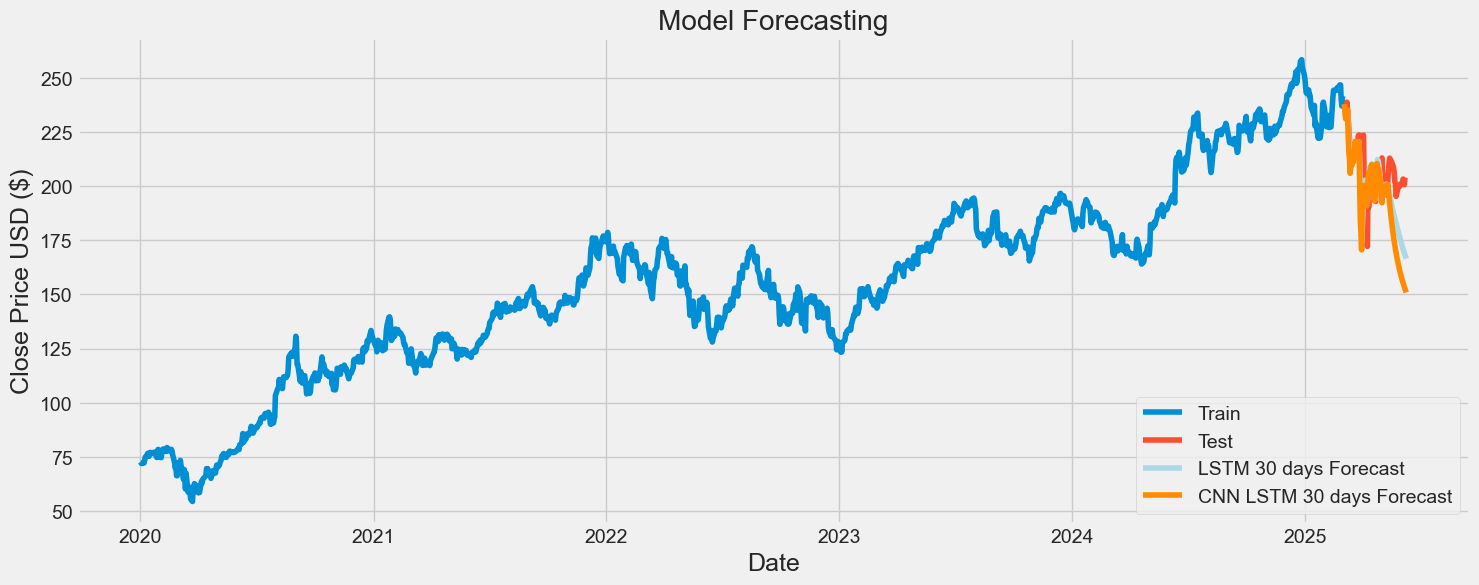

In [ ]:


# Plot everything
plt.figure(figsize=(16, 6))
plt.title('Model Forecasting')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

plt.plot(train, label='Train')
plt.plot(test['AAPL'], label='Test')

plt.plot(forecast_df['LSTM_Forecast'], label='LSTM 30 days Forecast', color='lightblue')
plt.plot(forecast_df['CNN_LSTM_Forecast'], label='CNN LSTM 30 days Forecast', color='darkorange')

plt.legend(loc='lower right')
plt.show()


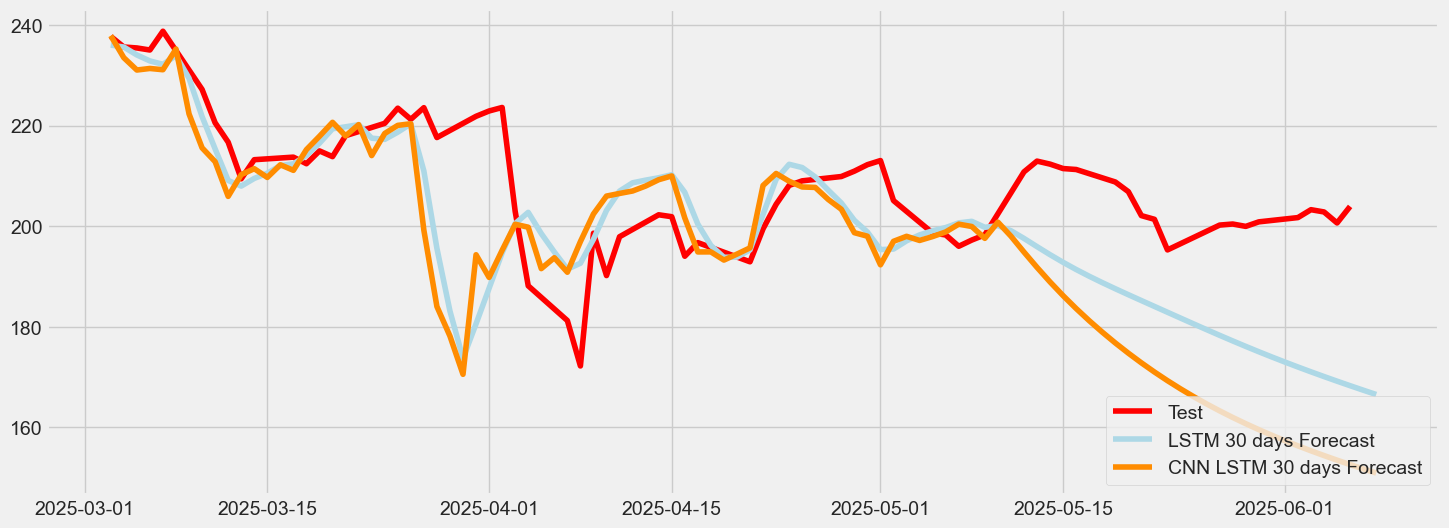

In [43]:
plt.figure(figsize=(16, 6))
plt.plot(test['AAPL'], label='Test', color='red')
plt.plot(forecast_df['LSTM_Forecast'], label='LSTM 30 days Forecast', color='lightblue')
plt.plot(forecast_df['CNN_LSTM_Forecast'], label='CNN LSTM 30 days Forecast', color='darkorange')

plt.legend(loc='lower right')
plt.show()


## Facebook Prophet

In [48]:
print(vars(future))

{'_is_copy': None, '_mgr': BlockManager
Items: Index(['ds'], dtype='object')
Axis 1: RangeIndex(start=0, stop=1395, step=1)
DatetimeLikeBlock: slice(0, 1, 1), 1 x 1395, dtype: datetime64[ns], '_item_cache': {}, '_attrs': {}, '_flags': <Flags(allows_duplicate_labels=True)>}


In [47]:
print(vars(forecast))

{'_is_copy': None, '_mgr': BlockManager
Items: Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
Axis 1: RangeIndex(start=0, stop=1395, step=1)
DatetimeLikeBlock: slice(0, 1, 1), 1 x 1395, dtype: datetime64[ns]
NumpyBlock: slice(1, 2, 1), 1 x 1395, dtype: float64
NumpyBlock: slice(2, 6, 1), 4 x 1395, dtype: float64
NumpyBlock: slice(6, 21, 1), 15 x 1395, dtype: float64
NumpyBlock: slice(21, 22, 1), 1 x 1395, dtype: float64, '_item_cache': {'trend': 0        71.055724
1        71.199231
2        71.629751
3        71.773258
4        71.916764
           ...    
1390    241.947336
1391    242.032026
1392    242.116717
1393   

In [49]:
print(vars(forecast))

{'_is_copy': None, '_mgr': BlockManager
Items: Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
Axis 1: RangeIndex(start=0, stop=1395, step=1)
DatetimeLikeBlock: slice(0, 1, 1), 1 x 1395, dtype: datetime64[ns]
NumpyBlock: slice(1, 2, 1), 1 x 1395, dtype: float64
NumpyBlock: slice(2, 6, 1), 4 x 1395, dtype: float64
NumpyBlock: slice(6, 21, 1), 15 x 1395, dtype: float64
NumpyBlock: slice(21, 22, 1), 1 x 1395, dtype: float64, '_item_cache': {'trend': 0        71.055724
1        71.199231
2        71.629751
3        71.773258
4        71.916764
           ...    
1390    241.947336
1391    242.032026
1392    242.116717
1393   

10:33:51 - cmdstanpy - INFO - Chain [1] start processing
10:33:51 - cmdstanpy - INFO - Chain [1] done processing


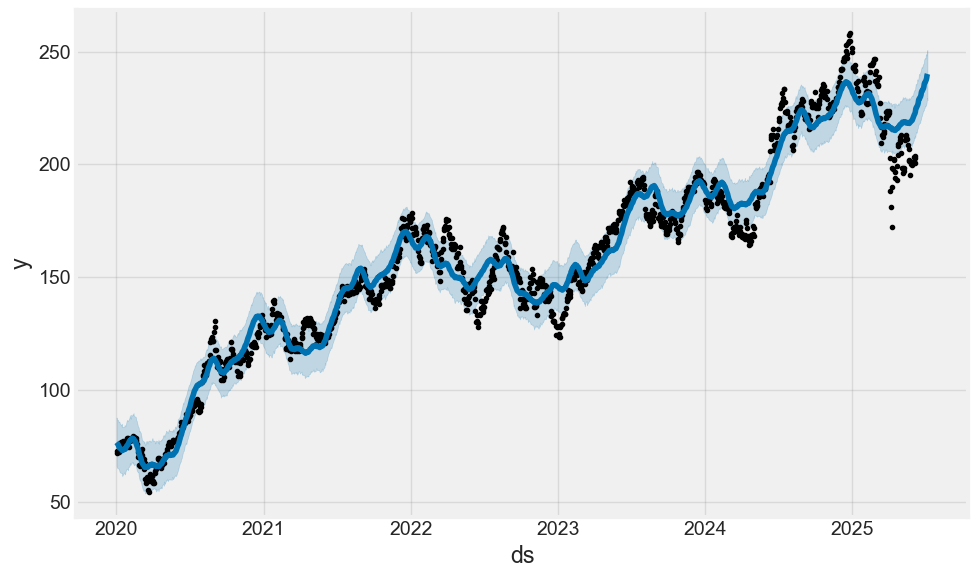

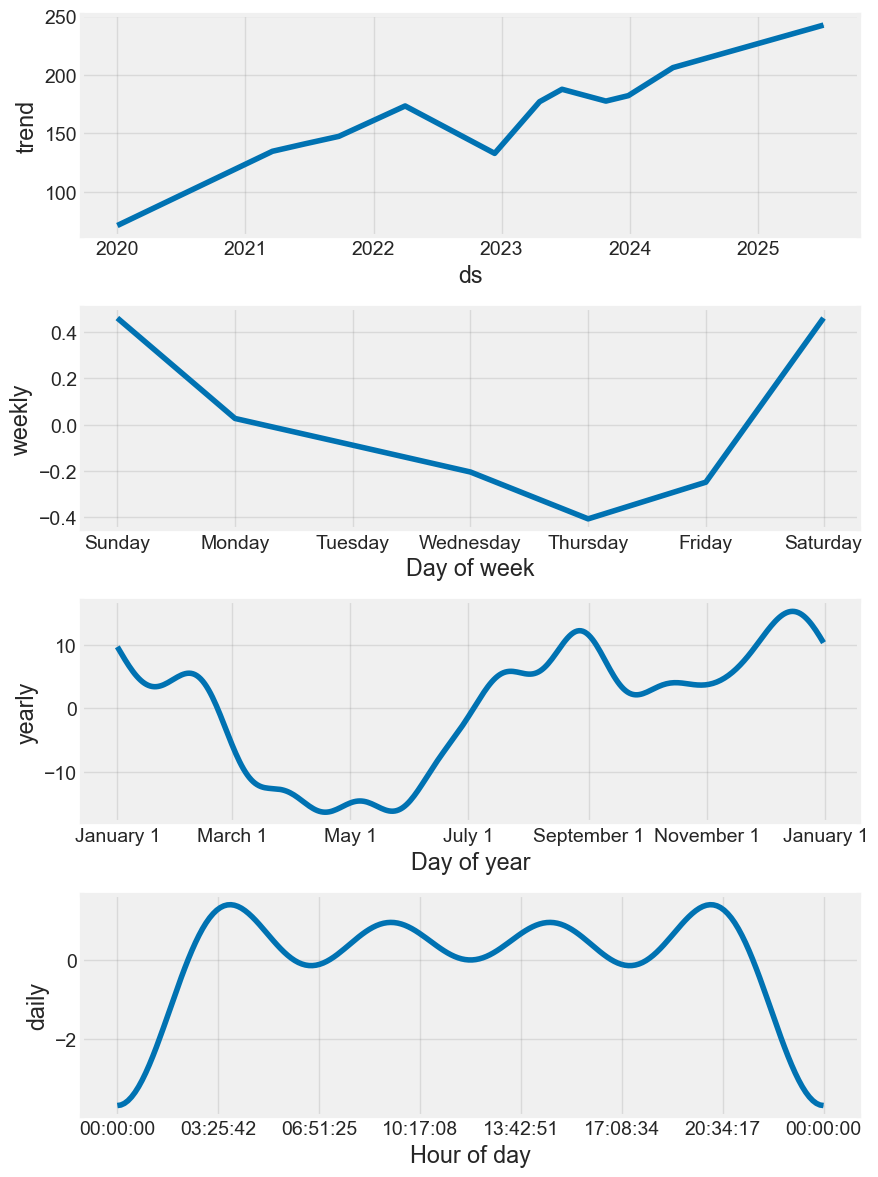

In [44]:
from prophet import Prophet


df_prophet = df['Close'].copy()
df_prophet.reset_index(inplace=True)
df_prophet.columns = ['ds', 'y']

model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=30)

# Predict future values
forecast = model.predict(future)
# Plot the forecast
fig1 = model.plot(forecast)

# Optional: Plot forecast components (trend, seasonality)
fig2 = model.plot_components(forecast)

In [56]:
rmse = np.sqrt(np.mean(((forecast.loc[:, 'yhat'] - df_prophet['y']) ** 2)))
print(f"Prophet Root Mean Squared Error(RMSE): {rmse}")


Prophet Root Mean Squared Error(RMSE): 8.551462938707823
